## Step 1: Time Series Preparation

### Problem Overview:
The goal of this project is to **forecast daily Superstore sales for the next 7 days** to support inventory planning and reduce stockouts and overstocking.

This is a **time series forecasting** problem — not traditional regression — since the `Sales` variable is dependent on **time-based patterns**.


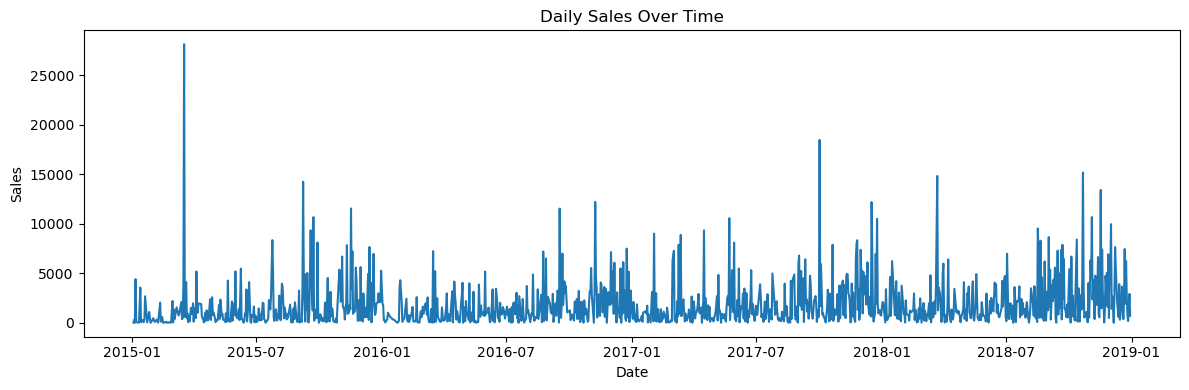

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("train 2.csv")

# Fix the date format
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

# Aggregate sales by day
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales = daily_sales.sort_values('Order Date')

# Plot the sales over time
plt.figure(figsize=(12, 4))
plt.plot(daily_sales['Order Date'], daily_sales['Sales'])
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()




## Step 2: Time-Based Train/Test Split

In [27]:
cutoff = int(len(daily_sales) * 0.8)
train = daily_sales.iloc[:cutoff]
test = daily_sales.iloc[cutoff:]


## Step 3: SARIMA Model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17630D+00    |proj g|=  1.42434D-01


 This problem is unconstrained.



At iterate    5    f=  9.10288D+00    |proj g|=  1.91611D-01

At iterate   10    f=  9.09599D+00    |proj g|=  2.11801D-02

At iterate   15    f=  9.09581D+00    |proj g|=  1.62565D-04

At iterate   20    f=  9.09581D+00    |proj g|=  2.14530D-03

At iterate   25    f=  9.09566D+00    |proj g|=  2.44141D-02

At iterate   30    f=  9.08283D+00    |proj g|=  1.42925D-01

At iterate   35    f=  9.05008D+00    |proj g|=  2.52014D-01

At iterate   40    f=  8.99233D+00    |proj g|=  2.22019D-01

At iterate   45    f=  8.97251D+00    |proj g|=  9.91402D-03

At iterate   50    f=  8.97250D+00    |proj g|=  1.75515D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

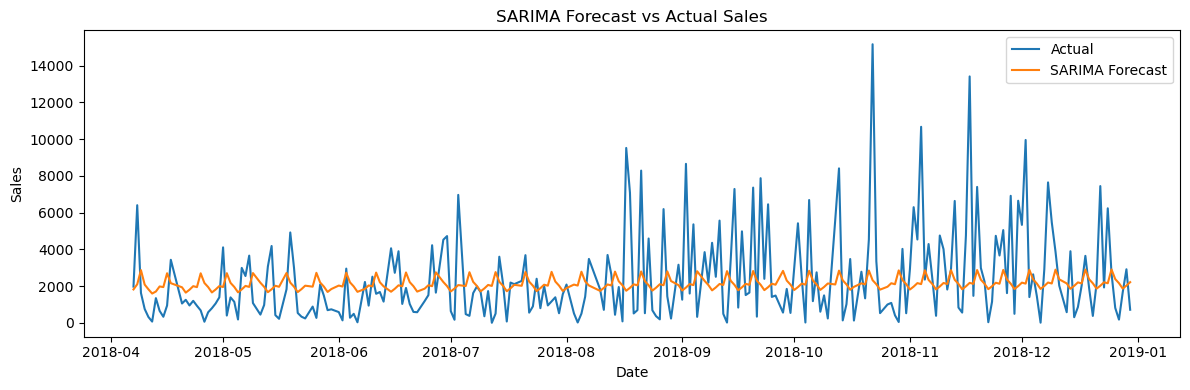

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

model = SARIMAX(train['Sales'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)

sarima_result = model.fit()

preds = sarima_result.predict(start=len(train),
                              end=len(train) + len(test) - 1,
                              dynamic=False)

plt.figure(figsize=(12, 4))
plt.plot(test['Order Date'], test['Sales'], label="Actual")
plt.plot(test['Order Date'], preds, label="SARIMA Forecast")
plt.title("SARIMA Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


## Steph 4 Linear Regression with Lag Features

In [45]:
# Copy the daily_sales to start creating lag features
df_lag = daily_sales.copy()
df_lag['Sales_t-1'] = df_lag['Sales'].shift(1)
df_lag['Sales_t-7'] = df_lag['Sales'].shift(7)
df_lag.dropna(inplace=True)  # Drop rows with NaN from shifting


In [47]:
# Define X and y
X_lag = df_lag[['Sales_t-1', 'Sales_t-7']]
y_lag = df_lag['Sales']


In [49]:
from sklearn.model_selection import train_test_split

X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test_split(
    X_lag, y_lag, test_size=0.2, shuffle=False  # No shuffle for time series
)


In [51]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_lag, y_train_lag)

# Predict
y_pred_lag = lr_model.predict(X_test_lag)


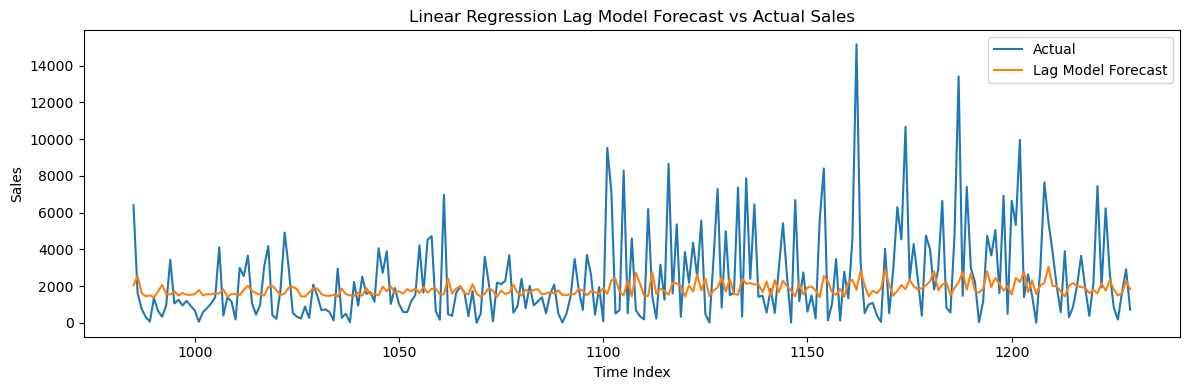

In [53]:
plt.figure(figsize=(12, 4))
plt.plot(y_test_lag.index, y_test_lag.values, label='Actual')
plt.plot(y_test_lag.index, y_pred_lag, label='Lag Model Forecast')
plt.title("Linear Regression Lag Model Forecast vs Actual Sales")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# SARIMA evaluation
sarima_mae = mean_absolute_error(test['Sales'], preds)
sarima_rmse = np.sqrt(mean_squared_error(test['Sales'], preds))

# Lag model evaluation
lag_mae = mean_absolute_error(y_test_lag, y_pred_lag)
lag_rmse = np.sqrt(mean_squared_error(y_test_lag, y_pred_lag))

print(f"SARIMA MAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}")
print(f"Lag Model MAE: {lag_mae:.2f}, RMSE: {lag_rmse:.2f}")



SARIMA MAE: 1761.55, RMSE: 2452.65
Lag Model MAE: 1716.42, RMSE: 2509.28


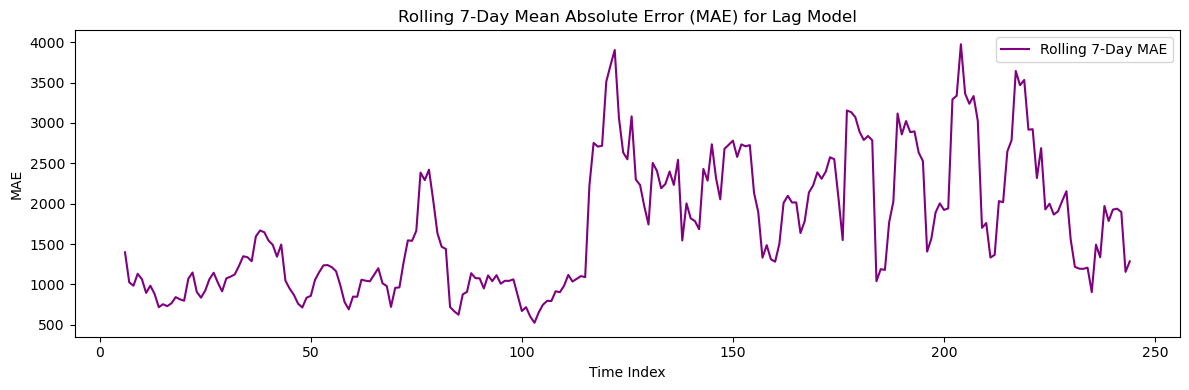

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 1. Load and process your data
df = pd.read_csv("train 2.csv")
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

# Aggregate by day
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index().sort_values('Order Date')

# 2. Create lag features
df_lag = daily_sales.copy()
df_lag['Sales_t-1'] = df_lag['Sales'].shift(1)
df_lag['Sales_t-7'] = df_lag['Sales'].shift(7)
df_lag.dropna(inplace=True)

# 3. Define X and y
X_lag = df_lag[['Sales_t-1', 'Sales_t-7']]
y_lag = df_lag['Sales']

# 4. Train/test split
X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test_split(
    X_lag, y_lag, test_size=0.2, shuffle=False
)

# 5. Fit model
lr_model = LinearRegression()
lr_model.fit(X_train_lag, y_train_lag)

# 6. Predict
y_pred_lag = lr_model.predict(X_test_lag)

# 7. Create DataFrame with actual & predicted
df_results = pd.DataFrame({
    'Actual': y_test_lag.values,
    'Predicted': y_pred_lag
}).reset_index(drop=True)

# 8. Rolling MAE calculation (7-day window)
rolling_mae = df_results['Actual'].rolling(window=7).apply(
    lambda x: mean_absolute_error(x, df_results.loc[x.index, 'Predicted']),
    raw=False
)

# 9. Plot Rolling MAE
plt.figure(figsize=(12, 4))
plt.plot(rolling_mae, label='Rolling 7-Day MAE', color='purple')
plt.title('Rolling 7-Day Mean Absolute Error (MAE) for Lag Model')
plt.xlabel('Time Index')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17630D+00    |proj g|=  1.42434D-01


 This problem is unconstrained.



At iterate    5    f=  9.10288D+00    |proj g|=  1.91611D-01

At iterate   10    f=  9.09599D+00    |proj g|=  2.11801D-02

At iterate   15    f=  9.09581D+00    |proj g|=  1.62565D-04

At iterate   20    f=  9.09581D+00    |proj g|=  2.14530D-03

At iterate   25    f=  9.09566D+00    |proj g|=  2.44141D-02

At iterate   30    f=  9.08283D+00    |proj g|=  1.42925D-01

At iterate   35    f=  9.05008D+00    |proj g|=  2.52014D-01

At iterate   40    f=  8.99233D+00    |proj g|=  2.22019D-01

At iterate   45    f=  8.97251D+00    |proj g|=  9.91402D-03

At iterate   50    f=  8.97250D+00    |proj g|=  1.75515D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

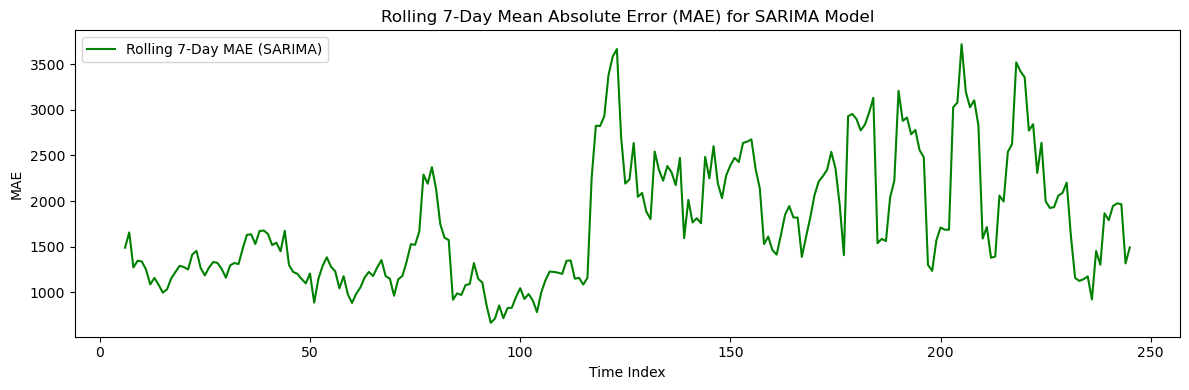

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# 1. Load and process the data
df = pd.read_csv("train 2.csv")
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

# 2. Aggregate daily sales
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index().sort_values('Order Date')

# 3. Split into train and test sets
cutoff = int(len(daily_sales) * 0.8)
train = daily_sales.iloc[:cutoff]
test = daily_sales.iloc[cutoff:]

# 4. Fit SARIMA model
sarima_model = SARIMAX(train['Sales'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 7),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

# 5. Forecast
sarima_preds = sarima_result.predict(start=len(train),
                                     end=len(train) + len(test) - 1,
                                     dynamic=False)

# 6. Create results DataFrame
sarima_results = pd.DataFrame({
    'Actual': test['Sales'].values,
    'Predicted': sarima_preds.values
}).reset_index(drop=True)

# 7. Calculate rolling MAE
rolling_mae_sarima = sarima_results['Actual'].rolling(window=7).apply(
    lambda x: mean_absolute_error(x, sarima_results.loc[x.index, 'Predicted']),
    raw=False
)

# 8. Plot Rolling MAE
plt.figure(figsize=(12, 4))
plt.plot(rolling_mae_sarima, label='Rolling 7-Day MAE (SARIMA)', color='green')
plt.title('Rolling 7-Day Mean Absolute Error (MAE) for SARIMA Model')
plt.xlabel('Time Index')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()



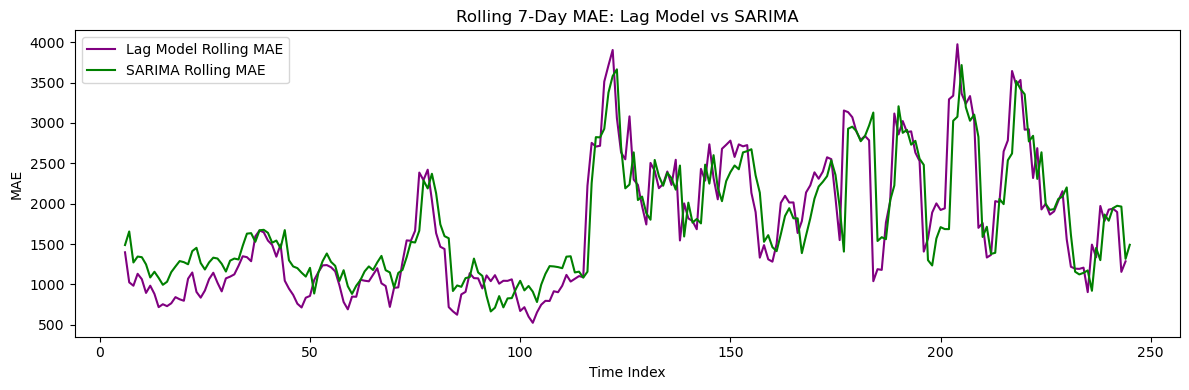

In [18]:
# Combine both rolling MAE series into one DataFrame
comparison_df = pd.DataFrame({
    'Lag_Model': rolling_mae,             # from previous Lag model chart
    'SARIMA': rolling_mae_sarima          # just calculated above
})

# Plot both lines
plt.figure(figsize=(12, 4))
plt.plot(comparison_df['Lag_Model'], label='Lag Model Rolling MAE', color='purple')
plt.plot(comparison_df['SARIMA'], label='SARIMA Rolling MAE', color='green')
plt.title('Rolling 7-Day MAE: Lag Model vs SARIMA')
plt.xlabel('Time Index')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


## Final Model Selection and Justification

### Problem Statement Recap:
What opportunities exist in the Superstore market to forecast sales for the next 7 days in order to:
- Optimize inventory decisions
- Reduce stockouts and overstocking
- Enable regional managers to respond proactively to demand shifts
- Support a data-driven supply chain strategy for the upcoming quarter

---

### Model Evaluation Summary

To address this problem, I tested two models using historical daily sales data:

| Model                     | MAE         | RMSE        |
|--------------------------|-------------|-------------|
| SARIMA                   | 1761.55     | 2452.65     |
| **Lag-Based Regression** | **1716.42** | 2509.28     |

---

### Final Model: Lag-Based Linear Regression

I selected the **Lag-Based Linear Regression model** as the final model for this project.

#### 💡 Why?
- It achieved the **lowest Mean Absolute Error (MAE)**, which is crucial for day-to-day inventory planning.
- It is simple and interpretable — regional managers and inventory planners can understand and trust the forecasts.
- The model relies on recent sales trends (lags), making it ideal for **short-term 7-day forecasting**.
- It can be easily updated with new sales data, ensuring adaptability in fast-changing environments.

---

### 📦 Business Impact:

This model supports Superstore's operational goals by:
- **Improving product availability** in top-performing categories
- **Reducing excess inventory costs** through more accurate short-term demand planning
- Empowering regional managers with **data-driven insights** they can act on quickly

Overall, the model contributes to a smarter, more responsive supply chain strategy for the upcoming quarter.
